In [23]:
import requests

# 定义基因名称和物种ID
gene_name = "A1BG"
taxonomy_id = "9606"  # 人类的taxonomy ID

# 构建UniProt API URL
uniprot_url = f"https://rest.uniprot.org/uniprotkb/search?query=gene:{gene_name}+AND+taxonomy_id:{taxonomy_id}&fields=accession,sequence&format=tsv"

# 发送HTTP请求获取数据
response = requests.get(uniprot_url)

# 检查响应状态
if response.status_code == 200:
    # 解析响应内容
    data = response.text
    print(data)
else:
    print(f"Failed to retrieve data: {response.status_code}")

Entry	Sequence
P04217	MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVTLTCQAHLETPDFQLFKNGVAQEPVHLDSPAIKHQFLLTGDTQGRYRCRSGLSTGWTQLSKLLELTGPKSLPAPWLSMAPVSWITPGLKTTAVCRGVLRGVTFLLRREGDHEFLEVPEAQEDVEATFPVHQPGNYSCSYRTDGEGALSEPSATVTIEELAAPPPPVLMHHGESSQVLHPGNKVTLTCVAPLSGVDFQLRRGEKELLVPRSSTSPDRIFFHLNAVALGDGGHYTCRYRLHDNQNGWSGDSAPVELILSDETLPAPEFSPEPESGRALRLRCLAPLEGARFALVREDRGGRRVHRFQSPAGTEALFELHNISVADSANYSCVYVDLKPPFGGSAPSERLELHVDGPPPRPQLRATWSGAVLAGRDAVLRCEGPIPDVTFELLREGETKAVKTVRTPGAAANLELIFVGPQHAGNYRCRYRSWVPHTFESELSDPVELLVAES
M0R009	LTCQAHLETPDFQLFKNGVAQEPVHLDSPAIKHQFLLTGDTQGRYRCRSGLSTGWTQLSKLLELTGPKSLPAPWLSMAPVSWITPGLKTTAVCRGVLRGVTFLLRREGDHEFLEVPEAQEDVEATFPVHQPGNYSCSYRTDGEGALSEPSATVTIEELGPGPGSWPHGCLGLMVAKEFGQRMPKEWKAAPPPPVLMHHGESSQVLHPGNKVTLTCVAPLSGVDFQLRRGEKELLVPRSSTSPDRIFFHLNAVALGDGGHYTCRYRLHDNQNGWSGDSAPVELILSDETLPAPEFSPEPESGRALR



In [27]:
# open gene list
with open('../data/processed_data/primekg_gene_list.txt', 'r') as f:
    primekg_gene_list = f.readlines()

primekg_gene_list = [gene.strip() for gene in primekg_gene_list]


len(primekg_gene_list)

['PHYKPL',
 'MIR362',
 'ANKFN1',
 'GK-IT1',
 'RNF113A',
 'XKRY',
 'FOCAD-AS1',
 'FAM85B',
 'CD200',
 'OR7E111P',
 'KLK8',
 'H2BS1',
 'PRR23D1',
 'SCNN1B',
 'PGM2L1',
 'CAPN11',
 'RPL27',
 'INO80',
 'CASC2',
 'ZNF578',
 'TNFSF4',
 'SUGT1P2',
 'PRKAA1',
 'ALDH1L2',
 'MIR623',
 'MT4',
 'LAMB3',
 'RAB3IP',
 'PTGR2',
 'PTPN14',
 'CAGE1',
 'SNORD115-15',
 'PPP1R42',
 'TNS1',
 'DAB1-AS1',
 'CRYGB',
 'ABLIM3',
 'HABP4',
 'SLC44A3-AS1',
 'ULK4P2',
 'DBNDD2',
 'AKR1C8P',
 'CDH2',
 'DDX18P5',
 'FBXL14',
 'SNORD22',
 'RNU6-652P',
 'GPR101',
 'LGMNP1',
 'POLR1A',
 'CD207',
 'MROH6',
 'FKBP8',
 'KDM4E',
 'LHFPL1',
 'BMPER',
 'SERPINA6',
 'CABS1',
 'SCDP1',
 'PCID2',
 'SLC2A6',
 'B3GNT6',
 'GAPDHP44',
 'RGMB-AS1',
 'NIPSNAP1',
 'SENP3-EIF4A1',
 'MUTYH',
 'LCE2A',
 'SNORD7',
 'IL10RA',
 'ZSCAN31',
 'KCTD16',
 'RTCA',
 'OR4K5',
 'FANCE',
 'C1QTNF9B',
 'ZFP36',
 'OR4D10',
 'MIR941-5',
 'RN7SL836P',
 'GTF2A2',
 'MTARC2',
 'BOP1',
 'CRYM-AS1',
 'MICOS10',
 'ASPN',
 'MFN2',
 'BTF3P7',
 'LINC01667',
 'SPATA

In [47]:
import requests
import pandas as pd
from tqdm import tqdm
import io
from concurrent.futures import ThreadPoolExecutor

# 假设你的基因名称列表如下
gene_list = primekg_gene_list

# 定义物种ID为人类
taxonomy_id = "9606"

# 准备存储结果的列表
results = []

# 定义一个函数来处理每个基因名称
def fetch_data(gene_name):
    # 构建UniProt API URL
    uniprot_url = f"https://rest.uniprot.org/uniprotkb/search?query=gene:{gene_name}+AND+taxonomy_id:{taxonomy_id}&fields=accession,gene_names,sequence&format=tsv"
    
    # 发送HTTP请求获取数据
    response = requests.get(uniprot_url)
    
    # 检查响应状态
    if response.status_code == 200:
        # 解析响应内容
        data = response.text
        # 将TSV格式的数据转换为Pandas DataFrame
        df = pd.read_csv(io.StringIO(data), sep='\t')
        
        # 存储结果
        local_results = []
        for index, row in df.iterrows():
            gene_names = row['Gene Names'].split()  # 拆分多个基因名称
            for gene in gene_names:
                local_results.append([gene, row['Entry'], row['Sequence']])
        return local_results
    else:
        print(f"Failed to retrieve data for gene: {gene_name}, status code: {response.status_code}")
        return []

# 使用ThreadPoolExecutor并发处理请求
with ThreadPoolExecutor(max_workers=16) as executor:
    # 使用tqdm显示进度条
    future_to_gene = {executor.submit(fetch_data, gene_name): gene_name for gene_name in gene_list}
    for future in tqdm(concurrent.futures.as_completed(future_to_gene), total=len(gene_list), desc="Fetching data from UniProt"):
        gene_name = future_to_gene[future]
        try:
            result = future.result()
            results.extend(result)
            
        except Exception as exc:
            print(f"{gene_name} generated an exception: {exc}")

# 将结果列表转换为Pandas DataFrame
results_df = pd.DataFrame(results, columns=["Gene Name", "UniProt ID", "Sequence"])

# 打印或保存结果
print(results_df)
results_df.to_csv("../data/processed_data/uniprot_results.csv", index=False)  # 保存为CSV文件



In [4]:
import pandas as pd
# load data

uniport_results_filtered_path = '../data/train_data/uniprot_results_filtered.csv'

df = pd.read_csv(uniport_results_filtered_path)

In [7]:
# count num of nan
print(df)
df.isnull().sum()

      Gene Name UniProt ID                                           Sequence
0          A1BG     P04217  MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...
1      A1BG-AS1        NaN                                                NaN
2          A1CF     F8W9F8  MEAVCLGTCPEPEASMSTAIPGLKKGNNALQSIILQTLLEKENGQR...
3           A2M     P01023  MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...
4       A2M-AS1        NaN                                                NaN
...         ...        ...                                                ...
27666    ZYG11A     Q6WRX3  MVHFLHPGHTPRNIVPPDAQKDALGCCVVQEEASPYTLVNICLNVL...
27667    ZYG11B     Q9C0D3  MPEDQAGAAMEEASPYSLLDICLNFLTTHLEKFCSARQDGTLCLQE...
27668       ZYX     Q9BUS0  PSPPGWRLLRTGTQSLRTRRRGGHPRRGAHAPACARPGHGGPPPVS...
27669     ZZEF1     O43149  MGNAPSHSSEDEAAAAGGEGWGPHQDWAAVSGTTPGPGVAAPALPP...
27670      ZZZ3     Q8IYH5  MAASRSTRVTRSTVGLNGLDESFCGRTLRNRSIAHPEEISSNSQVR...

[27671 rows x 3 columns]


Gene Name        0
UniProt ID    7483
Sequence      7483
dtype: int64

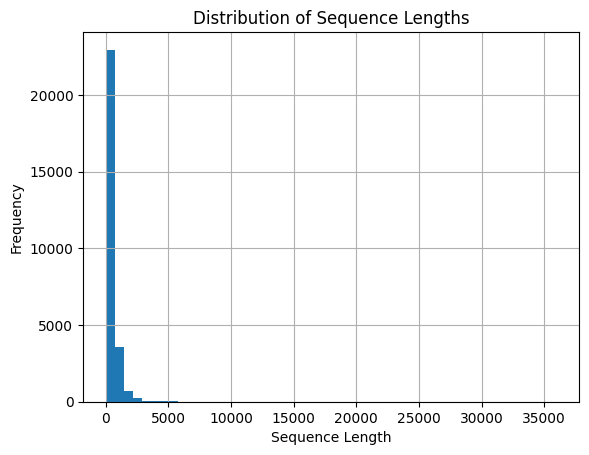

In [10]:
# visulize the length of sequence
import matplotlib.pyplot as plt

# 绘制序列长度的直方图
# 确保 'Sequence' 列中没有缺失值，并且所有值都是字符串
df['Sequence'] = df['Sequence'].fillna('').astype(str)

# 计算序列长度
df['Sequence Length'] = df['Sequence'].apply(len)

# 绘制序列长度的直方图
df['Sequence Length'].hist(bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

/public/sist/home/hongmt2022/k-bv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 10.491024186183038] is not finite

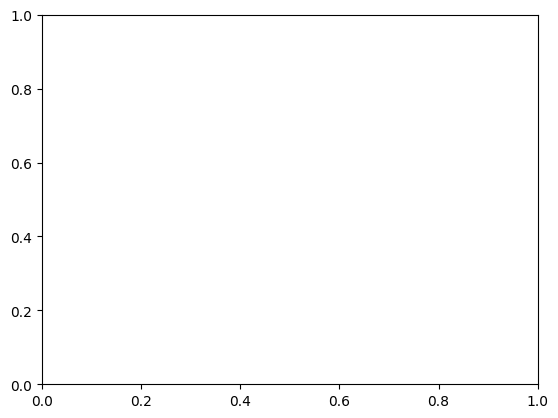

In [11]:
# apply log to sequence length
import numpy as np

# 计算序列长度的对数
df['Log Sequence Length'] = np.log(df['Sequence Length'])

# 绘制对数序列长度的直方图
# y 轴使用对数刻度
# 对 0 值进行处理，避免 log(0) 无法计算
df['Log Sequence Length'] = df['Log Sequence Length'].replace(-np.inf, 0)
df['Log Sequence Length'].hist(bins=50)
plt.yscale('log')
plt.xlabel('Log Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Log Sequence Lengths')
plt.show()

